In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii

from scipy import stats, interpolate
from scipy.integrate import quad, cumtrapz
from scipy.optimize import curve_fit

import sys
sys.path.append('../../')
import magnification_library as magnification_library
from magnification_library import *

import clmm
from clmm import utils 
import pyccl

from importlib import reload  

In [2]:
reload(magnification_library)

<module 'magnification_library' from '../../magnification_library.py'>

In [3]:
clmm.__version__

'1.0.0'

In [4]:
#define cosmology

#from https://arxiv.org/pdf/1904.13378.pdf%20for%20u-dropout BEWARE that CT backend can not handle sigma8

#astropy object
cosmo = FlatLambdaCDM(H0=67.7, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [5]:
#computation utils properties
z_s = np.linspace(0.001, 4, 1000)
zinf = 1000 

conv = cosmo.arcsec_per_kpc_proper(z_s) #.to(u.arcmin/u.Mpc)  #.to(u.deg/u.Mpc)

rproj = np.linspace(0.01, 10, 1000)

A = 1.*u.Mpc**2

def step_nan(x):
    return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1

# **1) Sources properties**

In [6]:
#lens properties 
z_cl = [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5]

## **Sources**

In [7]:
#CONVERSION BETWEEN VALUES IN CHANG ET AL. 2017 
#https://arxiv.org/pdf/1305.0793.pdf

#n, neff = 46, 37 #k=1, r+i, table1 Y10 values from table 1
n, neff = 46/np.sqrt(10),11 #k=1, r+i, Y1 values from table 1 and figure 6
#n, neff = 46/np.sqrt(2),23 #k=1, r+i, Y5 values from table 1 and figure 6

blend_eta, blend_mu = 0.68,5.5*1e-3 #d=2arcsec table 3.

neff_blend = (1-blend_eta*np.log(1+blend_mu*n))*neff
neff_blend_mask = 0.85*neff_blend
print(n,neff, neff_blend, neff_blend_mask)

14.546477236774544 11 10.424292455439407 8.860648587123496


In [112]:
#Source galaxies properties 
#(source shear shot noise or LF slope, source density, redshift distribution parametrization)

#SHEAR LSST__________________________________________________________________
# fiducial number for Y10 (Y1) after blending + masking https://arxiv.org/pdf/1305.0793.pdf
s_e = 0.26
n_e_Y10 = 26 /u.arcmin**2
n_e_Y1 = 9 /u.arcmin**2

def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return pdf_z(z, 1.24, 1.01, 0.51)*step_nan(z>0)*step_nan(z<3.)/norm

#MAGNIFICATION LSST g-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout

#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1i = 25.13 #i band
mlimY10i = 26.35 #i band

alpha_lbgg_Y1 = 2.5 * slope(mlimY1i, LF_param['alpha'][2], LF_param['m_star_UV'][2], beta=None,fct="schechter")
alpha_lbgg_Y10 = 2.5 * slope(mlimY10i, LF_param['alpha'][2], LF_param['m_star_UV'][2], beta=None,fct="schechter")

n_eff_lbgg_Y1 = (2*1e3/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
n_eff_lbgg_Y10 = (1e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 

def mu_lbgg_pdz(z):
    func = gaussian(z, 1, 3.8,0.68/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]


#MAGNIFICATION LSST u-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout

LF_param = {'z_eff':[2.,3.,3.8,4.9,5.9], 'phi_star':[97.0,50.4,92.5,32.2,16.4]*1/(cosmo.h*u.Mpc**3), 'alpha':[-1.60,-1.78,-1.57,-1.60,-1.87], 'm_star_UV':[24.2,24.7,25.4,25.5,25.8]}

#At z~3 the LSST band corresponding to UV ~ 1500 Angstrom is the r band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1r = 25.81 #r band
mlimY10r = 27.04 #r band

alpha_lbg_Y1 = 2.5 * slope(mlimY1r, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter")
alpha_lbg_Y10 = 2.5 * slope(mlimY10r, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter")

n_eff_lbg_Y1 = (1.8e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
n_eff_lbg_Y10 = (7.5*1e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 

def mu_lbg_pdz(z):
    func = gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]

#MAGNIFICATION LSST BX_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for BX-dropouts

#At z~2 the LSST band corresponding to UV ~ 1500 Angstrom is the g band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1g =  25.60 #g band
mlimY10g = 26.84 #g band

alpha_bx_Y1 = 2.5 * slope(mlimY1g, LF_param['alpha'][0], LF_param['m_star_UV'][0], beta=None,fct="schechter")
alpha_bx_Y10 = 2.5 * slope(mlimY10g, LF_param['alpha'][0], LF_param['m_star_UV'][0], beta=None,fct="schechter")

n_eff_bx_Y1 = (3e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
n_eff_bx_Y10 = (3.*1e5/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 

def mu_bx_pdz(z):
    func = gaussian(z, 1, 2.20,0.80/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.20,0.80/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]



#MAGNIFICATION Euclid/WFIRST Halpha_________________________________________________________
#https://arxiv.org/pdf/1710.00833.pdf

alpha_ha =  2. #based on manual check
n_eff_ha = (0.5 * 4256./(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
#based on 1/3 * (counts_Ferr + counts_Cal + counts_Char) f>2x10^{-16} + 50% estimation probability to measure the redshift

def halpha_pdz(z):
    """Redshift distribution function"""
    #func = np.heaviside((z>0.9),0)*np.heaviside((z<1.8),0)*(z**0.106482)*np.exp(-(z/0.58316767))
    func = step_nan(z>0.9)*step_nan(z<1.8)*(z**0.106482)*np.exp(-(z/0.58316767))
    return func/quad(lambda z: np.heaviside((z>0.9),0)*np.heaviside((z<1.8),0)*(z**0.106482)*np.exp(-(z/0.58316767)), 0, np.inf)[0]

#MAGNIFICATION DESI QSO_________________________________________________________
alpha_qso =  2.5 *0.197 #for QSO based on last raw of Table 1 in https://www.aanda.org/articles/aa/pdf/2017/12/aa31850-17.pdf
n_eff_qso = (170/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) #based on Table 3.1 in https://arxiv.org/pdf/1611.00036.pdf (measured redshift)

def mu_qso_pdz(z):
    norm =quad(QSO_pdf_z, 0, np.inf)[0]
    return QSO_pdf_z(z)/norm


In [113]:
print(abs(alpha_lbg_Y1-1) * n_eff_lbg_Y1.value, abs(alpha_lbg_Y10-1) * n_eff_lbg_Y10.value)
print(abs(alpha_lbgg_Y1-1) * n_eff_lbgg_Y1.value, abs(alpha_lbgg_Y10-1) * n_eff_lbgg_Y10.value)

print(abs(alpha_bx_Y1-1) * n_eff_bx_Y1.value, abs(alpha_bx_Y10-1) * n_eff_bx_Y10.value)

0.6987466757787119 2.169213841343484
0.47351699036445605 0.03647393480462643
1.0381427472181977 26.008145693075953


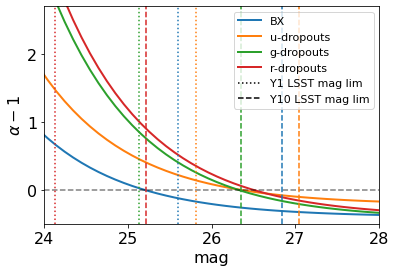

In [102]:
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1i = 25.13 #i band
mlimY10i = 26.35 #i band

#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1z = 24.13 #z band
mlimY10z = 25.22 #z band

m = np.linspace(20,30,100)

plt.plot(m, 2.5 * slope(m, LF_param['alpha'][0], LF_param['m_star_UV'][0], beta=None,fct="schechter") - 1, lw=2, label = 'BX')
plt.plot(m, 2.5 * slope(m, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter") - 1, lw=2, label = 'u-dropouts')
plt.plot(m, 2.5 * slope(m, LF_param['alpha'][2], LF_param['m_star_UV'][2], beta=None,fct="schechter") - 1, lw=2, label = 'g-dropouts')
plt.plot(m, 2.5 * slope(m, LF_param['alpha'][3], LF_param['m_star_UV'][3], beta=None,fct="schechter") - 1, lw=2, label = 'r-dropouts')
#plt.plot(m, 2.5 * slope(m, LF_param['alpha'][4], LF_param['m_star_UV'][4], beta=None,fct="schechter") - 1, lw=2)

plt.xlim(24,28)
plt.ylim(-0.5,2.7)

plt.axhline(0, color='black',alpha=0.5, linestyle='dashed')

plt.axvline(0, color= 'black',  linestyle='dotted', label='Y1 LSST mag lim')
plt.axvline(0, color= 'black',  linestyle='dashed', label='Y10 LSST mag lim')


plt.axvline(mlimY1g, color= 'C00',  linestyle='dotted')
plt.axvline(mlimY10g, color= 'C00',  linestyle='dashed')

plt.axvline(mlimY1r, color='C01',  linestyle='dotted')
plt.axvline(mlimY10r, color='C01',  linestyle='dashed')

plt.axvline(mlimY1i,  color='C02',  linestyle='dotted')
plt.axvline(mlimY10i,  color='C02',  linestyle='dashed')

plt.axvline(mlimY1z,  color='C03',  linestyle='dotted')
plt.axvline(mlimY10z,  color='C03',  linestyle='dashed')

plt.xlabel('mag')
plt.ylabel('$\\alpha - 1$')

plt.legend(fontsize='x-small')

In [10]:
print ("Source densities :\n ",\
       n_e_Y1, "for LSST shear (Y1) \n", \
       n_e_Y10, "for LSST shear (Y10) \n", \
       round(n_eff_qso.value,2)*n_eff_qso.unit, "for DESI QSO\n", \
       round(n_eff_ha.value,2)*n_eff_ha.unit, "for Euclid Halpha\n", \
       round(n_eff_lbg_Y1.value,2)*n_eff_lbg_Y1.unit,"for LSST LBG (Y1)\n", \
       round(n_eff_lbg_Y10.value,2)*n_eff_lbg_Y10.unit, "for LSST LBG (Y10)\n",\
       round(n_eff_bx_Y1.value,2)*n_eff_bx_Y1.unit,"for LSST BX (Y1) \n",\
       round(n_eff_bx_Y10.value,2)*n_eff_bx_Y10.unit,"for LSST BX (Y10)" )

Source densities :
  9.0 1 / arcmin2 for LSST shear (Y1) 
 26.0 1 / arcmin2 for LSST shear (Y10) 
 0.05 1 / arcmin2 for DESI QSO
 0.59 1 / arcmin2 for Euclid Halpha
 5.0 1 / arcmin2 for LSST LBG (Y1)
 20.83 1 / arcmin2 for LSST LBG (Y10)
 8.33 1 / arcmin2 for LSST BX (Y1) 
 83.33 1 / arcmin2 for LSST BX (Y10)


<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1


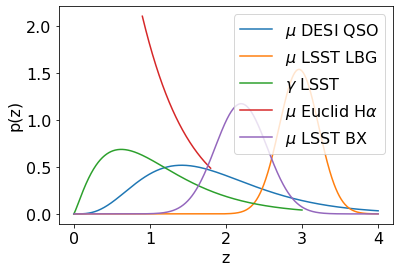

In [11]:
plt.plot(z_s, mu_qso_pdz(z_s), 'C0', label = '$\mu$ DESI QSO')
plt.plot(z_s, mu_lbg_pdz(z_s), 'C1',  label = '$\mu$ LSST LBG')
plt.plot(z_s, shear_pdz(z_s),  'C2', label = '$\gamma$ LSST')
plt.plot(z_s, halpha_pdz(z_s), 'C3', label = '$\mu$ Euclid H$\\alpha$')
plt.plot(z_s, mu_bx_pdz(z_s), 'C4', label = '$\mu$ LSST BX')

plt.xlabel('z')
plt.ylabel("p(z)")
plt.legend();

<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-12-22e3a848a9a1>:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "C1--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(z_s, n3*mu_lbg_pdz(z_s)*n_eff_lbg_Y1.value, 'C1--', linestyle='dotted', label = str(n3)+' x $\mu$ LSST Y1 LBG')
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-12-22e3a848a9a1>:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "C4--" (-> linestyle='--'). The keyword argument will take precedence.


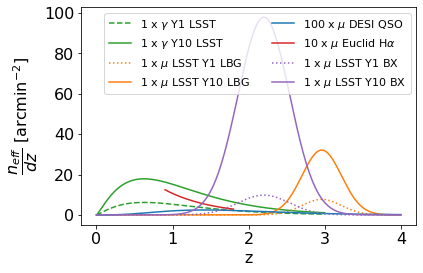

In [12]:
n1, n2, n3 = 100, 10, 1

plt.plot(z_s, n3*shear_pdz(z_s) *n_e_Y1.value,  'C2--', label = str(n3)+' x $\gamma$ Y1 LSST')
plt.plot(z_s, n3*shear_pdz(z_s) *n_e_Y10.value, 'C2', label = str(n3)+' x $\gamma$ Y10 LSST')

plt.plot(z_s, n3*mu_lbg_pdz(z_s)*n_eff_lbg_Y1.value, 'C1--', linestyle='dotted', label = str(n3)+' x $\mu$ LSST Y1 LBG')
plt.plot(z_s, n3*mu_lbg_pdz(z_s)*n_eff_lbg_Y10.value,'C1', label = str(n3)+' x $\mu$ LSST Y10 LBG')

plt.plot(z_s, n1*mu_qso_pdz(z_s)*n_eff_qso.value, 'C0', label = str(n1)+' x $\mu$ DESI QSO')

plt.plot(z_s, n2*halpha_pdz(z_s)*n_eff_ha.value, 'C3', label = str(n2)+' x $\mu$ Euclid H$\\alpha$')



plt.plot(z_s, n3*mu_bx_pdz(z_s)*n_eff_bx_Y1.value, 'C4--', linestyle='dotted', label = str(n3)+' x $\mu$ LSST Y1 BX')
plt.plot(z_s, n3*mu_bx_pdz(z_s)*n_eff_bx_Y10.value,'C4', label = str(n3)+' x $\mu$ LSST Y10 BX')



plt.xlabel('z')
plt.ylabel("$ \dfrac{n_{eff}}{dz}$ [arcmin$^{-2}$]")
plt.legend(fontsize='x-small',ncol=2);


In [13]:
Ngal_s_Y1       = shear_pdz(z_s)  * (n_e_Y1 *       A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_s_Y10      = shear_pdz(z_s)  * (n_e_Y10 *       A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_qso     = mu_qso_pdz(z_s) * (n_eff_qso * A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_ha      = halpha_pdz(z_s) * (n_eff_ha * A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_lbg_Y1  = mu_lbg_pdz(z_s) * (n_eff_lbg_Y1 * A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_lbg_Y10 = mu_lbg_pdz(z_s) * (n_eff_lbg_Y10 * A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_bx_Y1  = mu_bx_pdz(z_s) * (n_eff_bx_Y1 * A * (conv.to(u.arcmin/u.Mpc))**2).value
Ngal_mu_bx_Y10 = mu_bx_pdz(z_s) * (n_eff_bx_Y10 * A * (conv.to(u.arcmin/u.Mpc))**2).value

<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1


# $\frac{N_{eff}}{dz} = \frac{d n_{eff}}{dz}.A_{1Mpc}(z) $   

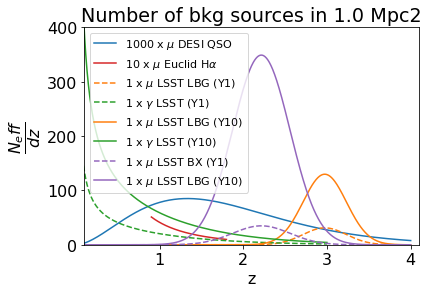

In [14]:
n1, n2, n3 = 1000, 10, 1

plt.title("Number of bkg sources in "+str(A))

plt.plot(z_s, n1*Ngal_mu_qso, 'C0',  label = str(n1)+' x $\mu$ DESI QSO')
plt.plot(z_s, n2*Ngal_mu_ha, 'C3',  label = str(n2)+' x $\mu$ Euclid H$\\alpha$')
plt.plot(z_s, n3*Ngal_mu_lbg_Y1, 'C1--', label = str(n3)+' x $\mu$ LSST LBG (Y1)')
plt.plot(z_s, n3*Ngal_s_Y1, 'C2--', label = str(n3)+' x $\gamma$ LSST (Y1)')
plt.plot(z_s, n3*Ngal_mu_lbg_Y10, 'C1', label = str(n3)+' x $\mu$ LSST LBG (Y10)')
plt.plot(z_s, n3*Ngal_s_Y10, 'C2', label = str(n3)+' x $\gamma$ LSST (Y10)')

plt.plot(z_s, n3*Ngal_mu_bx_Y1, 'C4--', label = str(n3)+' x $\mu$ LSST BX (Y1)')
plt.plot(z_s, n3*Ngal_mu_bx_Y10, 'C4', label = str(n3)+' x $\mu$ LSST LBG (Y10)')

plt.xlabel('z')
plt.ylabel("$\dfrac{N_eff}{dz}$")
plt.legend(loc="best", fontsize='x-small',ncol=1)

plt.xlim(0.1,4.1)
plt.ylim(0,400);

In [15]:
cum_Ngal_s_Y1       =  np.nancumsum(Ngal_s_Y1)*(z_s[1]-z_s[0])
cum_Ngal_s_Y10      =  np.nancumsum(Ngal_s_Y10)*(z_s[1]-z_s[0])
cum_Ngal_mu_qso     =  cumtrapz(Ngal_mu_qso, z_s,initial=0)
cum_Ngal_mu_ha     =  np.nancumsum(Ngal_mu_ha)*(z_s[1]-z_s[0])#cumtrapz(Ngal_mu_ha, z_s,initial=0)
cum_Ngal_mu_lbg_Y1  =  cumtrapz(Ngal_mu_lbg_Y1, z_s,initial=0)
cum_Ngal_mu_lbg_Y10 =  cumtrapz(Ngal_mu_lbg_Y10, z_s,initial=0)
cum_Ngal_mu_bx_Y1  =  cumtrapz(Ngal_mu_bx_Y1, z_s,initial=0)
cum_Ngal_mu_bx_Y10 =  cumtrapz(Ngal_mu_bx_Y10, z_s,initial=0)

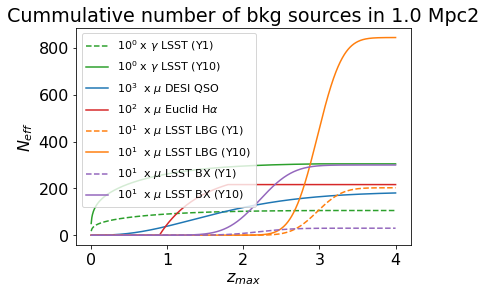

In [16]:
n1, n2, n3 = 1000, 10, 1

plt.title("Cummulative number of bkg sources in "+str(A))

plt.plot(z_s, n3* cum_Ngal_s_Y1,'C2--',       label = '10$^{' +str(round(np.log10(n3)))+ '}$ x $\gamma$ LSST (Y1)')
plt.plot(z_s, n3* cum_Ngal_s_Y10,'C2-',      label = '10$^{' +str(round(np.log10(n3)))+ '}$ x $\gamma$ LSST (Y10)')
plt.plot(z_s, n1* cum_Ngal_mu_qso,'-C0',    label = '10$^{' +str(round(np.log10(n1)))+ '}$  x $\mu$ DESI QSO')
plt.plot(z_s, n2**2 * cum_Ngal_mu_ha,'-C3',    label = '10$^{' +str(round(np.log10(n2**2)))+ '}$  x $\mu$ Euclid H$\\alpha$')
plt.plot(z_s, n2* cum_Ngal_mu_lbg_Y1,'C1--',  label = '10$^{' +str(round(np.log10(n2)))+ '}$  x $\mu$ LSST LBG (Y1)')
plt.plot(z_s, n2* cum_Ngal_mu_lbg_Y10,'C1-', label = '10$^{' +str(round(np.log10(n2)))+ '}$  x $\mu$ LSST LBG (Y10)')
plt.plot(z_s, n3* cum_Ngal_mu_bx_Y1,'C4--',  label = '10$^{' +str(round(np.log10(n2)))+ '}$  x $\mu$ LSST BX (Y1)')
plt.plot(z_s, n3* cum_Ngal_mu_bx_Y10,'C4-', label = '10$^{' +str(round(np.log10(n2)))+ '}$  x $\mu$ LSST BX (Y10)')

plt.xlabel('$z_{max}$')
plt.ylabel("$N_{eff}$")
plt.legend(fontsize='x-small');


# **2) Lensing strenght**

## **Shear and convergence profiles**

## $ \frac{|\gamma_\inf|}{\kappa_{inf}} = \frac{\Delta\Sigma (R)} {\Sigma (R)}$

## **Redshift distribution**

# $\beta_s(z_s) = \frac{D_{LS}}{D_S}\frac{D_{\inf}}{D_{L,\inf}}$

In [17]:
B = np.zeros((len(z_cl), z_s.size))
Bs = np.zeros((len(z_cl), z_s.size))

for i in range(len(z_cl)):
    B[i,:] = beta(z_cl[i], z_s, cosmo_clmm)
    Bs[i,:] = beta_s(z_cl[i], z_s, zinf, cosmo_clmm)

# $<\beta_s(z_s)> = <\frac{D_{LS}}{D_S}>\frac{D_{\inf}}{D_{L,\inf}}$
# $<\beta(z_s)> = <\frac{D_{LS}}{D_S}> = \frac{\int_{z_{s,min}}^{z_{s,max}} n(z) \beta(z)  \mathrm{d}z}{\int_{z_{s,min}}^{z_{s,max}} n(z)  \mathrm{d}z} $

<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1


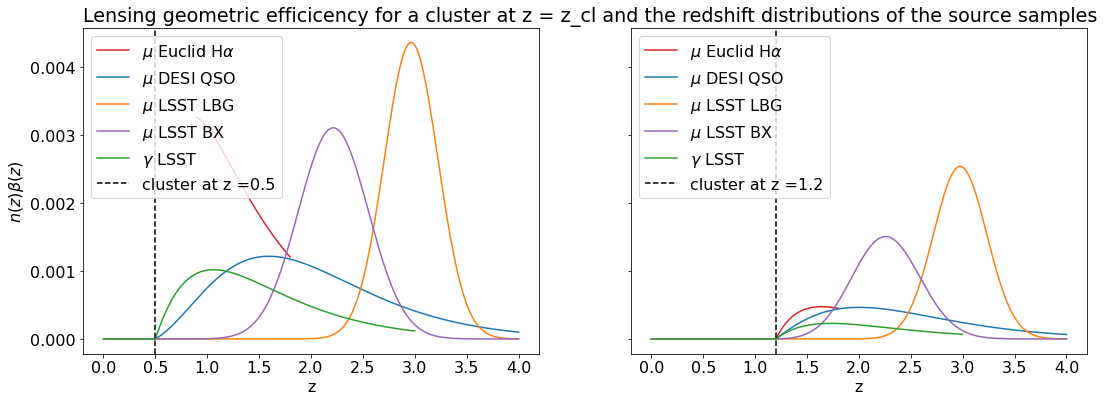

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=True, sharey=True)


ax1.set_title('Lensing geometric efficicency for a cluster at z = z_cl and the redshift distributions of the source samples', loc='left')

i = 2
ax1.plot(z_s, B[i,:] * halpha_pdz(z_s)/np.nansum(halpha_pdz(z_s)), 'C3', label = '$\mu$ Euclid H$\\alpha$')
ax1.plot(z_s, B[i,:] * mu_qso_pdz(z_s)/np.nansum(mu_qso_pdz(z_s)), 'C0', label = '$\mu$ DESI QSO')
ax1.plot(z_s, B[i,:] * mu_lbg_pdz(z_s)/np.nansum(mu_lbg_pdz(z_s)),'C1', label = '$\mu$ LSST LBG')
ax1.plot(z_s, B[i,:] * mu_bx_pdz(z_s)/np.nansum(mu_bx_pdz(z_s)),'C4', label = '$\mu$ LSST BX')
ax1.plot(z_s, B[i,:] * shear_pdz(z_s)/np.nansum(shear_pdz(z_s)), 'C2',label = '$\gamma$ LSST')
ax1.axvline(z_cl[i], color='black',linestyle="dashed", label = 'cluster at z ='+str(z_cl[i]))

ax1.set_ylabel("$n(z) \\beta(z)$")
ax1.set_xlabel('z')
ax1.legend();

i = 5
ax2.plot(z_s, B[i,:] * halpha_pdz(z_s)/np.nansum(halpha_pdz(z_s)), 'C3',label = '$\mu$ Euclid H$\\alpha$')
ax2.plot(z_s, B[i,:] * mu_qso_pdz(z_s)/np.nansum(mu_qso_pdz(z_s)), 'C0',label = '$\mu$ DESI QSO')
ax2.plot(z_s, B[i,:] * mu_lbg_pdz(z_s)/np.nansum(mu_lbg_pdz(z_s)), 'C1',label = '$\mu$ LSST LBG')
ax2.plot(z_s, B[i,:] * mu_bx_pdz(z_s)/np.nansum(mu_bx_pdz(z_s)),'C4', label = '$\mu$ LSST BX')
ax2.plot(z_s, B[i,:] * shear_pdz(z_s)/np.nansum(shear_pdz(z_s)), 'C2',label = '$\gamma$ LSST')
ax2.axvline(z_cl[i], color='black',linestyle="dashed", label = 'cluster at z ='+str(z_cl[i]))


ax2.set_xlabel('z')
ax2.legend();

In [19]:
B_mean = np.zeros((5, len(z_cl)))
B2_mean = np.zeros((5, len(z_cl)))
Bs_mean = np.zeros((5, len(z_cl)))

pdz = [ shear_pdz,  mu_lbg_pdz, mu_qso_pdz, halpha_pdz, mu_bx_pdz]

for i in range(len(z_cl)):

    B_mean[0, i] = compute_B_mean(z_cl[i], pdz[0], cosmo_clmm)
    B_mean[1, i] = compute_B_mean(z_cl[i], pdz[1], cosmo_clmm)
    B_mean[2, i] = compute_B_mean(z_cl[i], pdz[2], cosmo_clmm)
    B_mean[3, i] = compute_B_mean(z_cl[i], pdz[3], cosmo_clmm)
    B_mean[4, i] = compute_B_mean(z_cl[i], pdz[4], cosmo_clmm)
    
    Bs_mean[0, i] = B_mean[0, i] / beta(z_cl[i],zinf,cosmo_clmm)
    Bs_mean[1, i] = B_mean[1, i] / beta(z_cl[i],zinf,cosmo_clmm)
    Bs_mean[2, i] = B_mean[2, i] / beta(z_cl[i],zinf,cosmo_clmm)
    Bs_mean[3, i] = B_mean[3, i] / beta(z_cl[i],zinf,cosmo_clmm)
    Bs_mean[4, i] = B_mean[4, i] / beta(z_cl[i],zinf,cosmo_clmm)
    
    B2_mean[0, i] = np.nansum( B[i,:]**2 * pdz[0](z_s)) / np.nansum(pdz[0](z_s))
    B2_mean[1, i] = np.nansum( B[i,:]**2 * pdz[1](z_s)) / np.nansum(pdz[1](z_s))
    B2_mean[2, i] = np.nansum( B[i,:]**2 * pdz[2](z_s)) / np.nansum(pdz[2](z_s))    
    B2_mean[3, i] = np.nansum( B[i,:]**2 * pdz[3](z_s)) / np.nansum(pdz[3](z_s))   
    B2_mean[4, i] = np.nansum( B[i,:]**2 * pdz[4](z_s)) / np.nansum(pdz[3](z_s))  
        
B_mean_shear, B_mean_mu_LBG, B_mean_mu_qso, B_mean_mu_ha, B_mean_mu_BX= B_mean
Bs_mean_shear, Bs_mean_mu_LBG, Bs_mean_mu_qso, Bs_mean_mu_ha, Bs_mean_mu_BX = Bs_mean
B2_mean_shear, B2_mean_mu_LBG, B2_mean_mu_qso, B2_mean_mu_ha, B2_mean_mu_BX = B2_mean

<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1


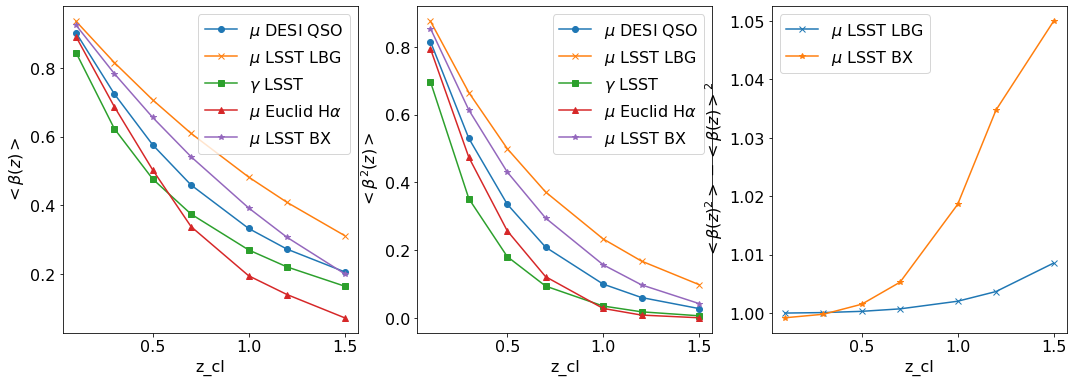

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(18,6), sharex=True)#, sharey=True)

ax1.plot(z_cl, B_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
ax1.plot(z_cl, B_mean_mu_LBG, 'x-', label = '$\mu$ LSST LBG')
ax1.plot(z_cl, B_mean_shear, 's-',  label = '$\gamma$ LSST')
ax1.plot(z_cl, B_mean_mu_ha, '^-',  label = '$\mu$ Euclid H$\\alpha$')
ax1.plot(z_cl, B_mean_mu_BX, '*-', label = '$\mu$ LSST BX')

ax1.set_ylabel("$<\\beta(z)>$")
ax1.set_xlabel('z_cl')
ax1.legend();

ax2.plot(z_cl, B2_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
ax2.plot(z_cl, B2_mean_mu_LBG, 'x-', label = '$\mu$ LSST LBG')
ax2.plot(z_cl, B2_mean_shear, 's-',  label = '$\gamma$ LSST')
ax2.plot(z_cl, B2_mean_mu_ha, '^-',  label = '$\mu$ Euclid H$\\alpha$')
ax2.plot(z_cl, B2_mean_mu_BX, '*-', label = '$\mu$ LSST BX')


ax2.set_ylabel("$<\\beta^2(z)>$")
ax2.set_xlabel('z_cl')
ax2.legend();

#Eq.12 in https://arxiv.org/pdf/1611.03866.pdf and Eq.6 and note in https://academic.oup.com/mnras/article/439/1/48/963939
#ax3.plot(z_cl, (B2_mean_mu_qso/B_mean_mu_qso -1)*B_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
#ax3.plot(z_cl, (B2_mean_mu_LBG/B_mean_mu_LBG -1)*B_mean_mu_qso, 'x-', label = '$\mu$ LSST LBG')
#ax3.plot(z_cl, (B2_mean_shear/B_mean_shear -1)*B_mean_mu_qso, 's-',  label = '$\gamma$ LSST')
#ax3.plot(z_cl, (B2_mean_mu_ha/B_mean_mu_ha -1)*B_mean_mu_ha, '^-',  label = '$\mu$ Euclid H$\\alpha$')



#Eq.12 in https://arxiv.org/pdf/1611.03866.pdf and Eq.6 and note in https://academic.oup.com/mnras/article/439/1/48/963939
#ax3.plot(z_cl, (B2_mean_mu_qso/B_mean_mu_qso**2), 'o-', label = '$\mu$ DESI QSO')
ax3.plot(z_cl, (B2_mean_mu_LBG/B_mean_mu_LBG**2), 'x-', label = '$\mu$ LSST LBG')
#ax3.plot(z_cl, (B2_mean_shear/B_mean_shear**2), 's-',  label = '$\gamma$ LSST')
#ax3.plot(z_cl, (B2_mean_mu_ha/B_mean_mu_ha**2), '^-',  label = '$\mu$ Euclid H$\\alpha$')
ax3.plot(z_cl, (B2_mean_mu_BX/B_mean_mu_BX**2), '*-', label = '$\mu$ LSST BX')

ax3.set_ylabel("$<\\beta(z)^2> - <\\beta(z)>^2 $")
ax3.set_xlabel('z_cl')
ax3.legend();

### The corrections of the form $<\beta(z)^2> - <\beta(z)> $ are negligeable. Thus we use $<g> \approx <\gamma> \approx <\beta_s>\gamma_{inf}$

# **Plots for publication**

<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1


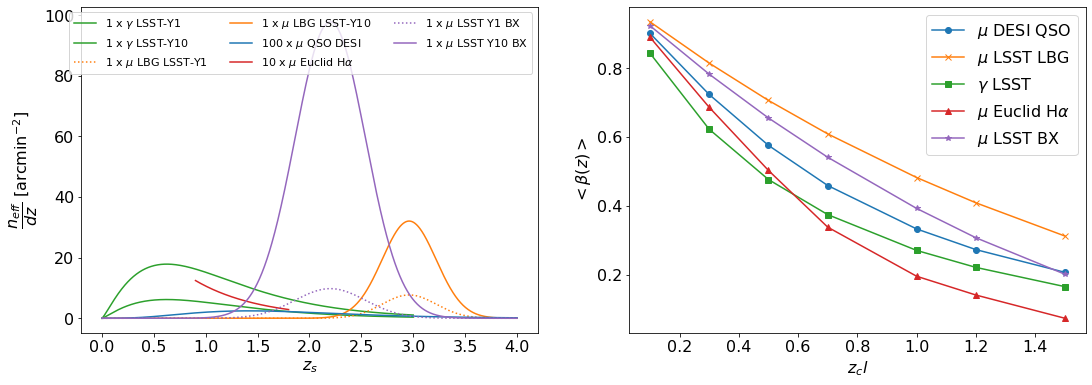

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=False)


n1, n2, n3 = 100, 10, 1

ax1.plot(z_s, n3*shear_pdz(z_s) *n_e_Y1.value,  'C2', label = str(n3)+' x $\gamma$ LSST-Y1')
ax1.plot(z_s, n3*shear_pdz(z_s) *n_e_Y10.value, 'C2', label = str(n3)+' x $\gamma$ LSST-Y10')

ax1.plot(z_s, n3*mu_lbg_pdz(z_s)*n_eff_lbg_Y1.value, 'C1', linestyle='dotted', label = str(n3)+' x $\mu$ LBG LSST-Y1')
ax1.plot(z_s, n3*mu_lbg_pdz(z_s)*n_eff_lbg_Y10.value,'C1', label = str(n3)+' x $\mu$ LBG LSST-Y10')

ax1.plot(z_s, n1*mu_qso_pdz(z_s)*n_eff_qso.value, 'C0', label = str(n1)+' x $\mu$ QSO DESI')

ax1.plot(z_s, n2*halpha_pdz(z_s)*n_eff_ha.value, 'C3', label = str(n2)+' x $\mu$ Euclid H$\\alpha$')

ax1.plot(z_s, n3*mu_bx_pdz(z_s)*n_eff_bx_Y1.value, 'C4', linestyle='dotted', label = str(n3)+' x $\mu$ LSST Y1 BX')
ax1.plot(z_s, n3*mu_bx_pdz(z_s)*n_eff_bx_Y10.value,'C4', label = str(n3)+' x $\mu$ LSST Y10 BX')


ax1.set_xlabel('$z_s$')
ax1.set_ylabel("$ \dfrac{n_{eff}}{dz}$ [arcmin$^{-2}$]")
ax1.legend(fontsize='x-small',ncol=3,loc='upper right');




ax2.plot(z_cl, B_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
ax2.plot(z_cl, B_mean_mu_LBG, 'x-', label = '$\mu$ LSST LBG')
ax2.plot(z_cl, B_mean_shear, 's-',  label = '$\gamma$ LSST')
ax2.plot(z_cl, B_mean_mu_ha, '^-',  label = '$\mu$ Euclid H$\\alpha$')
ax2.plot(z_cl, B_mean_mu_BX, '*-', label = '$\mu$ LSST BX')

ax2.set_ylabel("$<\\beta(z)>$")
ax2.set_xlabel('$z_cl$')
ax2.legend();

<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1
<ipython-input-5-fa7dfdf07937>:12: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(np.heaviside(x,0)), neginf=np.nan) - 1


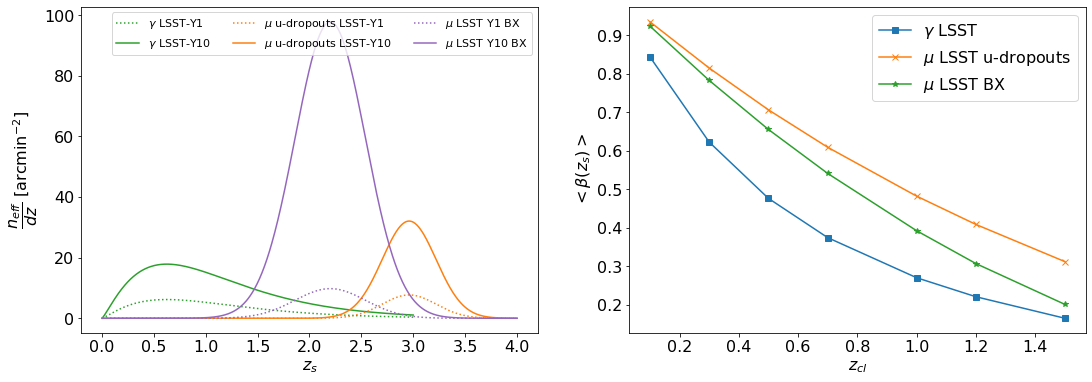

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=False)


n1, n2, n3 = 100, 10, 1

ax1.plot(z_s, n3*shear_pdz(z_s) *n_e_Y1.value,  'C2',  linestyle='dotted', label = '$\gamma$ LSST-Y1')
ax1.plot(z_s, n3*shear_pdz(z_s) *n_e_Y10.value, 'C2', label = '$\gamma$ LSST-Y10')

ax1.plot(z_s, n3*mu_lbg_pdz(z_s)*n_eff_lbg_Y1.value, 'C1', linestyle='dotted', label = '$\mu$ u-dropouts LSST-Y1')
ax1.plot(z_s, n3*mu_lbg_pdz(z_s)*n_eff_lbg_Y10.value,'C1', label = '$\mu$ u-dropouts LSST-Y10')

#ax1.plot(z_s, n1*mu_qso_pdz(z_s)*n_eff_qso.value, 'C0', label = str(n1)+' x $\mu$ QSO DESI')

#ax1.plot(z_s, n2*halpha_pdz(z_s)*n_eff_ha.value, 'C3', label = str(n2)+' x $\mu$ Euclid H$\\alpha$')

ax1.plot(z_s, n3*mu_bx_pdz(z_s)*n_eff_bx_Y1.value, 'C4', linestyle='dotted', label = '$\mu$ LSST Y1 BX')
ax1.plot(z_s, n3*mu_bx_pdz(z_s)*n_eff_bx_Y10.value,'C4', label = '$\mu$ LSST Y10 BX')


ax1.set_xlabel('$z_s$')
ax1.set_ylabel("$ \dfrac{n_{eff}}{dz}$ [arcmin$^{-2}$]")
ax1.legend(fontsize='x-small',ncol=3,loc='upper right');



ax2.plot(z_cl, B_mean_shear, 's-',  label = '$\gamma$ LSST')
#ax2.plot(z_cl, B_mean_mu_qso, 'o-', label = '$\mu$ DESI QSO')
ax2.plot(z_cl, B_mean_mu_LBG, 'x-', label = '$\mu$ LSST u-dropouts')

#ax2.plot(z_cl, B_mean_mu_ha, '^-',  label = '$\mu$ Euclid H$\\alpha$')
ax2.plot(z_cl, B_mean_mu_BX, '*-', label = '$\mu$ LSST BX')

ax2.set_ylabel("$<\\beta(z_s)>$")
ax2.set_xlabel('$z_{cl}$')
ax2.legend();